In [1]:
import numpy as np
import lbg_forecast.dust_priors as dpr
import lbg_forecast.sfh as sfh
import lbg_forecast.population_model as pop
import matplotlib.pyplot as plt

import lbg_forecast.priors_gp_dust as gpdp

Loading Models
Loading Complete


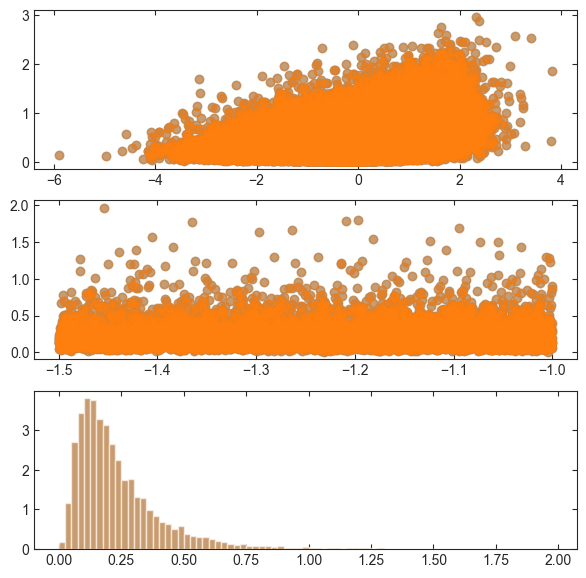

In [2]:
dust_prior = gpdp.DustPrior('./')
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(100000)

new_sfrs = recent_sfrs#np.random.uniform(-4, 3, 100000)
dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(new_sfrs)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(recent_sfrs, dust2, alpha=0.5)
ax[0].scatter(new_sfrs, dust2_gp, alpha=0.5)

sfr_point = -1
inds0 = np.where((recent_sfrs<sfr_point)&(recent_sfrs>sfr_point-0.5))[0]
inds = np.where((new_sfrs<sfr_point)&(new_sfrs>sfr_point-0.5))[0]
ax[1].scatter(recent_sfrs[inds0], dust2[inds0], alpha=0.5)
ax[1].scatter(new_sfrs[inds], dust2_gp[inds], alpha=0.5)

bins = np.arange(0, 2, 0.025)
histogram = ax[2].hist(dust2[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust2_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


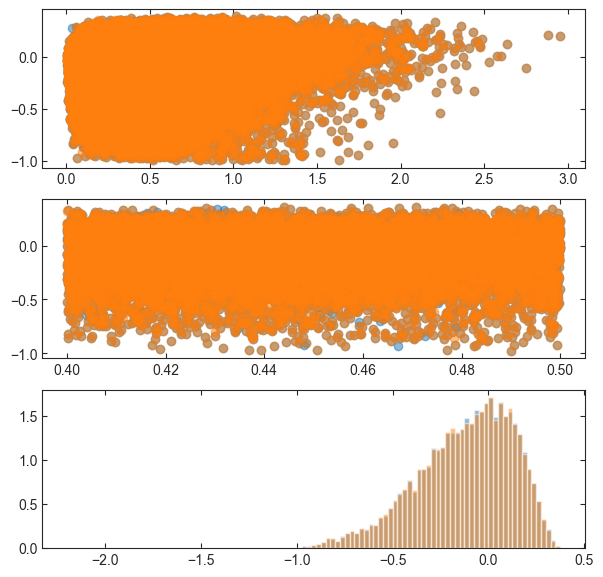

In [7]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(100000)

dust_prior = gpdp.DustPrior('./')
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = dust2#np.random.uniform(0, 4, 500000)
dust_index_gp = dust_prior.sample_dust_index(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(dust2, dust_index, alpha=0.5)
ax[0].scatter(dust2_gp, dust_index_gp, alpha=0.5)

dust2_point = 0.5
inds0 = np.where((dust2<dust2_point)&(dust2>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(dust2[inds0], dust_index[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust_index_gp[inds], alpha=0.5)

bins = np.arange(-2.2, 0.4, 0.025)
histogram = ax[2].hist(dust_index[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust_index_gp[inds], density=True, bins=bins, alpha=0.5)

In [4]:
import torch
f_preds_mu = gpdp.gp_evaluate_model(dust_prior.model_dust_index, torch.from_numpy(dust_prior.dust_index_grid))
mean_dust_index_sample = f_preds_mu.sample().numpy()
mean_dust_index = f_preds_mu.mean.detach().numpy()
delta_dust_index = mean_dust_index_sample - mean_dust_index
delta = np.interp(dust_prior.dust2, dust_prior.dust_index_grid, delta_dust_index)

sorted_inds = dust_prior.dust2.argsort()[:]
sorted_dust2 = dust_prior.dust2[sorted_inds]
sorted_dust_index = dust_prior.dust_index[sorted_inds]
sorted_delta = delta[sorted_inds]

dust2s = dust2

dust_index = np.interp(dust2s, sorted_dust2, sorted_dust_index)
delta = np.interp(dust2s, sorted_dust2, sorted_delta)

In [5]:
def draw_popcosmos_samples(nsamples):

    recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(nsamples)

    indexes = np.random.uniform(0, nsamples, nsamples)
    drawn_sfrs = recent_sfrs[indexes]
    drawn_dust2 = dust2[indexes]
    drawn_dust_index = dust_index[indexes]
    drawn_dust1 = dust1[indexes]

    return drawn_sfrs, drawn_dust2, drawn_dust_index, drawn_dust1

In [6]:
#np.save("dust_data/popcosmos_recentsfrs.npy", dust_prior.recent_sfrs)
#nagaraj22 = np.array([dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr])
#np.save("dust_data/saved_nagaraj22samples.npy", nagaraj22)

dust_prior = gpdp.DustPrior('.')

f, ax = plt.subplots(1, 3, figsize=(15, 5))

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

test_sfr = np.linspace(-5, 3, 500)
dust2 = dust_prior.sample_dust2(test_sfr)
dust_index = dust_prior.sample_dust_index(dust2)
dust1 = dust_prior.sample_dust1(dust2)

ax1.scatter(test_sfr, dust2)
ax2.scatter(dust2, dust_index)
ax3.scatter(dust2, dust1)

from duste.DustAttnCalc import DustAttnCalc
ngal = 2000

logM = np.random.uniform(8.74,11.30,ngal)
sfr = np.random.uniform(-5,2.5,ngal)
logZ = np.random.uniform(-1.70,0.18,ngal)
z=np.random.uniform(0.51,2.83,ngal)
i=np.random.uniform(0.09,0.97,ngal)
dobj = DustAttnCalc(sfr=sfr, logM=logM, logZ=logZ, z=z, i=i, bv=True, eff=False)
dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

plt.scatter(sfr, tau)